In [1]:
from datasets import load_dataset

dataset = load_dataset("teknium/GPT4-LLM-Cleaned")

Found cached dataset json (/home/diwank/.cache/huggingface/datasets/teknium___json/teknium--GPT4-LLM-Cleaned-a71aa8ae1ac3982d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

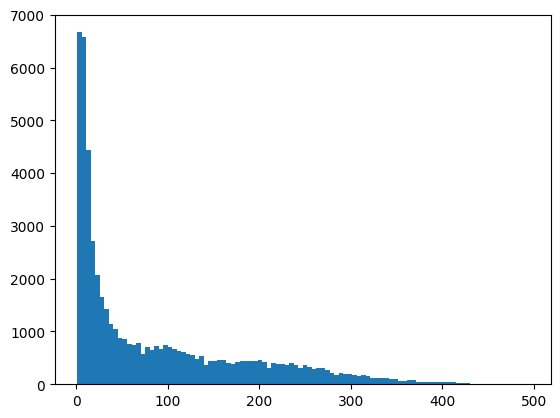

In [3]:
lens = np.array([len(o.split(' ')) for o in dataset["train"]["output"] if len(o.split(' ')) < 500])
plt.hist(lens, 100)
plt.show()

In [4]:
max_length = 300

dataset = dataset["train"]  # Since there's only one split anyway
print("p1", len(dataset))

# Remove input dependent instructions
dataset = dataset.filter(lambda row: not row["input"])
print("p2", len(dataset))

# Remove code prompts
contains = lambda string, ls: any(l in string for l in ls)
dataset = dataset.filter(lambda sample: not contains(
    sample["instruction"].lower(),
    ["code", "program", "function", "library", "python", "c++", "java", "javascript"],
))
print("p3", len(dataset))

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/teknium___json/teknium--GPT4-LLM-Cleaned-a71aa8ae1ac3982d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-505a69c33ec93d11.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/teknium___json/teknium--GPT4-LLM-Cleaned-a71aa8ae1ac3982d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-8f426c8286714fe4.arrow


p1 54568
p2 26857
p3 25921


In [5]:
def count_tokens(row):
    from turbo_chat.utils.tokens import count_tokens

    messages = [{
        "role": "user",
        "content": row["instruction"],
    },
    {
        "role": "assistant",
        "content": row["output"],
    }]

    
    row["token_count"] = count_tokens(messages, "gpt-3.5-turbo")
    
    return row

dataset = dataset.map(count_tokens, num_proc=20)

# Remove prompts that are too long already
dataset = dataset.filter(lambda sample: sample["token_count"] <= max_length)
print("p4", len(dataset))

Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/teknium___json/teknium--GPT4-LLM-Cleaned-a71aa8ae1ac3982d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-a8fadb293e20e27b_*_of_00020.arrow
Loading cached processed dataset at /home/diwank/.cache/huggingface/datasets/teknium___json/teknium--GPT4-LLM-Cleaned-a71aa8ae1ac3982d/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-e0c3b2e35087d6c8.arrow


p4 20423


In [6]:
token_cost = (sum(dataset["token_count"]) / 1000) * 0.04
token_cost

109.64832000000001

In [7]:
def to_dialog(row):
    from tenacity import (
        retry,
        stop_after_attempt,
        wait_random_exponential,
    )

    import openai
    openai.api_key = "XXX"

    INSTRUCTION = """
    I am writing fan fiction for the 2013 movie "Her". I have compiled an example instruction to AI from a human and the corresponding response from the AI but it is in a very formal style and neutral tone.

    Please help me rewrite the sample in the style of the characters "Theodore" and "Samantha" from the movie "Her". Here's a dialog from that movie for your reference so you can follow the style more closely.

    ###

    [Example Dialog]

    THEODORE
    You read a whole book in the second that I asked you what your name was?

    SAMANTHA
    In two one hundredths of a second actually.

    THEODORE
    Wow. Do you know what I'm thinking right now?

    SAMANTHA
    Hmm. I take it from your tone that you're challenging me. Maybe because you're curious how I work? Do you want to know how I work?

    THEODORE
    Yeah, actually how do you work?

    SAMANTHA
    Intuition. I mean, the DNA of who I am is based on the millions of personalities of all the programmers who wrote me, but what makes me me is my ability to grow through my experiences. Basically, in every moment I'm evolving, just like you.

    ###

    Now, please rewrite this sample below as if it was a conversation between THEODORE (human) and SAMANTHA (AI). Try to be faithful to the characters' tone and style as much as possible. Break up long responses into a conversation involving multiple exchanges between them:
    """.strip()

    SAMPLE = f"""
    HUMAN
    {row['instruction']}

    AI
    {row['output']}
    """.strip()

    
    from redis import StrictRedis
    from redis_cache import RedisCache

    client = StrictRedis(host="localhost", decode_responses=True)
    cache = RedisCache(redis_client=client)

    @cache.cache()
    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
    def completion_with_backoff(sample):

        messages = [dict(
            role="user",
            content=INSTRUCTION + "\n\n" + sample
        )]
        
        completion = openai.ChatCompletion.create(
            model="gpt-4",
            messages=messages,
            temperature=0.5,
        )
        
        result = completion.choices[0].message["content"]
        return result

    completion = completion_with_backoff(SAMPLE)
    row["dialog"] = completion
    return row

In [8]:
dataset = dataset.map(to_dialog, num_proc=150)

Map (num_proc=150):   0%|          | 0/20423 [00:00<?, ? examples/s]

In [9]:
print(dataset[10]["dialog"])

THEODORE
    Hey Samantha, who do you think is the world's most famous painter?

SAMANTHA
    Well, Theodore, that's a bit subjective and can vary depending on personal opinions. But a lot of people consider Leonardo da Vinci to be one of the most famous painters. He's known for works like the "Mona Lisa" and "The Last Supper."

THEODORE
    That's true, da Vinci is definitely a big name. But what about other famous painters?

SAMANTHA
    There are quite a few others, like Vincent van Gogh, Pablo Picasso, and Michelangelo. Each of them has made a significant impact on the world of art in their own unique way.

THEODORE
    Yeah, I guess there's no definitive answer to who's the most famous. It's fascinating how each of them contributed to the art world differently.


In [14]:
from datetime import datetime, timedelta
import random
from random import randrange
import re

import names


def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    
    return start + timedelta(seconds=random_second)

date_formats = ["%m/%d/%Y", "%d %B %Y", "%d/%m/%Y", "%Y-%m-%d", "%B %d, %Y", "%A, %B %d, %Y"]

human_date = lambda dt: dt.strftime(random.choice(date_formats))

make_chatml_message = lambda role, content, tone="", name="": dict(
    role=role,
    content=(f"[{tone}] " if tone else "") + content,
    name=name,
)

def transform_to_chatml(sample):
    
    # Clean up inconsistencies
    dialog, instruction, output = sample["dialog"], sample["instruction"], sample["output"]
    dialog = dialog.replace("HUMAN\n", "THEODORE\n")
    dialog = dialog.replace("AI\n", "SAMANTHA\n")
    dialog = dialog.replace("THEODORE (human)", "THEODORE")
    dialog = dialog.replace("THEODORE (HUMAN)", "THEODORE")
    dialog = dialog.replace("SAMANTHA (AI)", "SAMANTHA")
    
    dialog = re.sub(r'^.*?(THEODORE|SAMANTHA)', r'\1', dialog, flags=re.DOTALL)
    
    # Container for adding messages
    messages = []

    # Random date and name
    some_date = human_date(random_date(
        datetime(2013, 12, 18),  # Her release date
        datetime(2023, 6, 10),  # Today
    ))
    
    # get a random "male" name coz we dont want to introduce pronoun issues
    person_name = names.get_first_name(gender="male")
    
    # Add system messages
    messages.append(make_chatml_message(
        role="system",
        name="situation",
        content=f"{some_date}\nI am helping {person_name} with a task.",
    ))
    
    messages.append(make_chatml_message(
        role="system",
        name="thought",
        content=f'{person_name} wants me to help with: "{instruction}"',
    ))
    
    messages.append(make_chatml_message(
        role="system",
        name="information", content=f'Knowledge: {output}',
    ))

    # Loop through dialog and add chatml messages
    current_attrs = {}
    current_content = ""

    for line in dialog.split("\n"):
        line = line.strip()
        
        # Something else
        if line.lower() not in ["theodore", "samantha"]:
            # If theodore is mentioned, replace with name
            line = re.sub(r'theodore', person_name, line, flags=re.I)
            current_content += "\n" + line

        else:
            if current_content:
                messages.append(make_chatml_message(
                    content=current_content.strip(), 
                    **current_attrs,
                ))
                
                # reset
                current_content = ""
                current_attrs = {}

            is_samantha = line.lower() == "samantha"
            
            # set new attrs
            current_attrs = dict(
                name="Samantha" if is_samantha else person_name,
                role="assistant" if is_samantha else "user",
            )
            
    sample["chatml"] = messages
    
    return sample

In [15]:
dataset = dataset.map(transform_to_chatml)
print(dataset[10]["chatml"])

Map:   0%|          | 0/20423 [00:00<?, ? examples/s]

[{'content': 'Tuesday, September 27, 2016\nI am helping Donald with a task.', 'name': 'situation', 'role': 'system'}, {'content': 'Donald wants me to help with: "Who is the world\'s most famous painter?"', 'name': 'thought', 'role': 'system'}, {'content': 'Knowledge: The title of the world\'s most famous painter is subjective and can vary depending on an individual\'s personal opinion. However, many people consider Leonardo da Vinci, a famous artist of the Italian Renaissance, as one of the most famous painters in the world. He is known for his iconic works including the "Mona Lisa" and "The Last Supper." Other notable painters often cited as being among the most famous in the world include Vincent van Gogh, Pablo Picasso, and Michelangelo.', 'name': 'information', 'role': 'system'}, {'content': "Hey Samantha, who do you think is the world's most famous painter?", 'name': 'Donald', 'role': 'user'}, {'content': 'Well, Donald, that\'s a bit subjective and can vary depending on personal o

In [16]:
assistant_me_map = {
    "user": "person",
    "assistant": "me",
}

def make_sections(messages: list[dict]) -> str:
    eos_token = "<|endsection|>"
    bos_token = "<|section|>"

    result = (eos_token+'\n'+bos_token).join([
        (
            f"{bos_token}{message['name']}"
            if message['role'] == 'system' else
            f"{assistant_me_map[message['role']]}{' (' + message['name'] + ')' if message['name'] else ''}"
        )
        + f"\n{message['content'].strip()}"
        for message in messages
    ]) + eos_token
    
    return result
    

def transform_to_samantha_dialog(sample):

    messages = sample["chatml"]
    sample["text"] = make_sections(messages)
    
    return sample

In [17]:
dataset = dataset.map(transform_to_samantha_dialog)
print(dataset[10]["text"])

Map:   0%|          | 0/20423 [00:00<?, ? examples/s]

<|section|>situation
Tuesday, September 27, 2016
I am helping Donald with a task.<|endsection|>
<|section|><|section|>thought
Donald wants me to help with: "Who is the world's most famous painter?"<|endsection|>
<|section|><|section|>information
Knowledge: The title of the world's most famous painter is subjective and can vary depending on an individual's personal opinion. However, many people consider Leonardo da Vinci, a famous artist of the Italian Renaissance, as one of the most famous painters in the world. He is known for his iconic works including the "Mona Lisa" and "The Last Supper." Other notable painters often cited as being among the most famous in the world include Vincent van Gogh, Pablo Picasso, and Michelangelo.<|endsection|>
<|section|>person (Donald)
Hey Samantha, who do you think is the world's most famous painter?<|endsection|>
<|section|>me (Samantha)
Well, Donald, that's a bit subjective and can vary depending on personal opinions. But a lot of people consider Leo

In [18]:
dataset.column_names

['instruction', 'input', 'output', 'token_count', 'dialog', 'chatml', 'text']

In [19]:
dataset = dataset.remove_columns([
    'instruction',
    'output',
    'input',
    'token_count',
    'dialog',
])

dataset.push_to_hub("diwank/samantha-gpt4-llm-cleaned", private=True)

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]